## Library

In [58]:
import pandas as pd
import numpy as np

import os

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

## Dataset

In [2]:
Tess = "Tess"

In [3]:
paths = []
labels = []

for dirname, _, filenames in os.walk(Tess):
    for filename in filenames:
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

tess_directory_list = os.listdir(Tess)


Dataset is Loaded


In [4]:
df = pd.DataFrame({'path':paths, 'label':labels})

In [5]:
df.head()

,path,label
0,Tess\OAF_angry\OAF_back_angry.wav,angry
1,Tess\OAF_angry\OAF_bar_angry.wav,angry
2,Tess\OAF_angry\OAF_base_angry.wav,angry
3,Tess\OAF_angry\OAF_bath_angry.wav,angry
4,Tess\OAF_angry\OAF_bean_angry.wav,angry


In [6]:
df.shape


(2800, 2)

## EDA

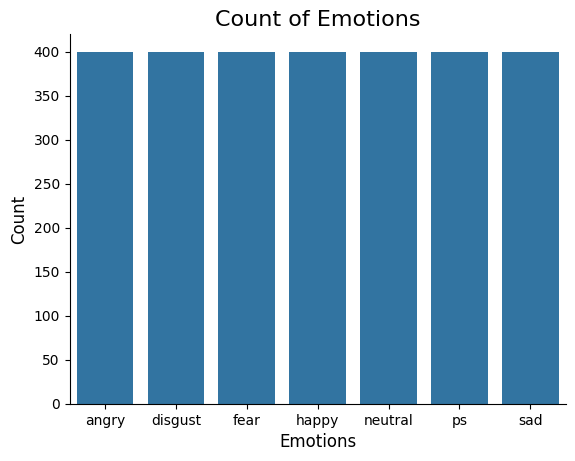

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(x = df.label)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

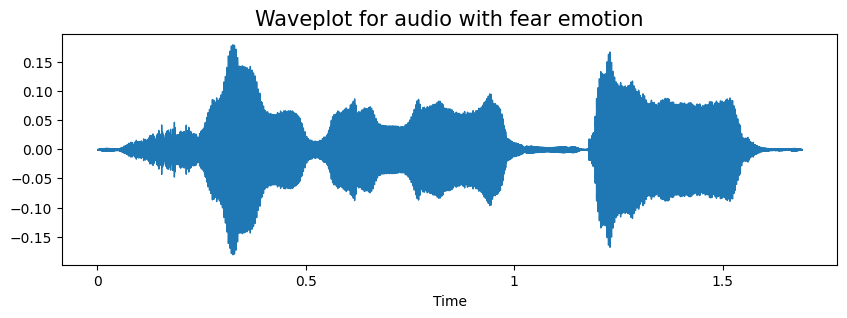

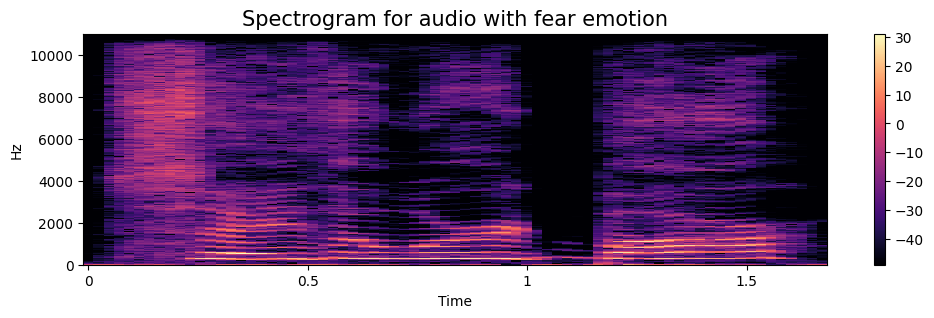

In [9]:
emotion='fear'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

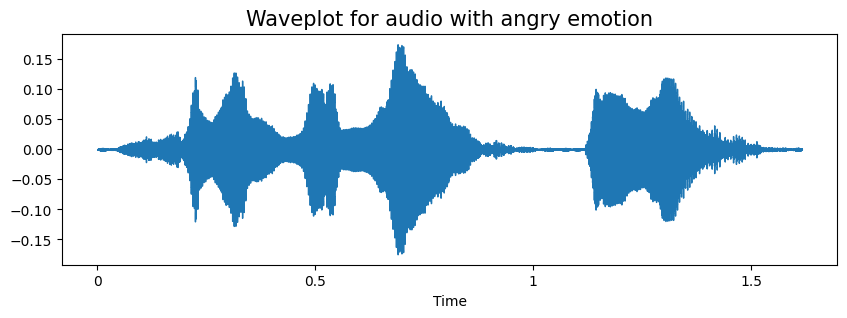

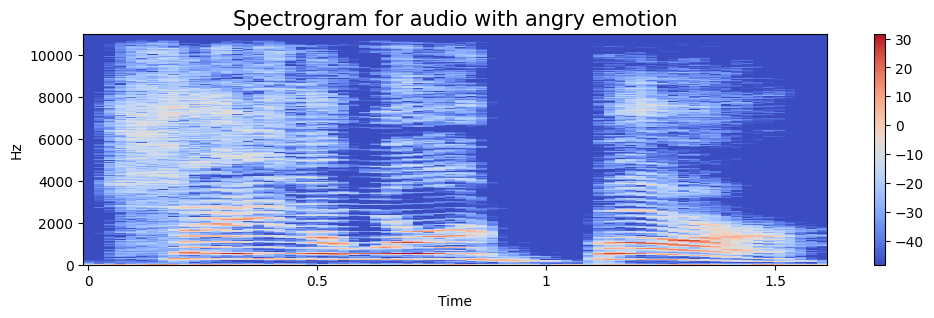

In [10]:
emotion='angry'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

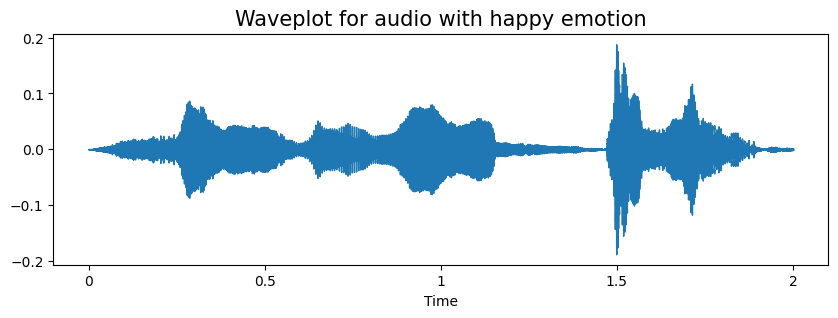

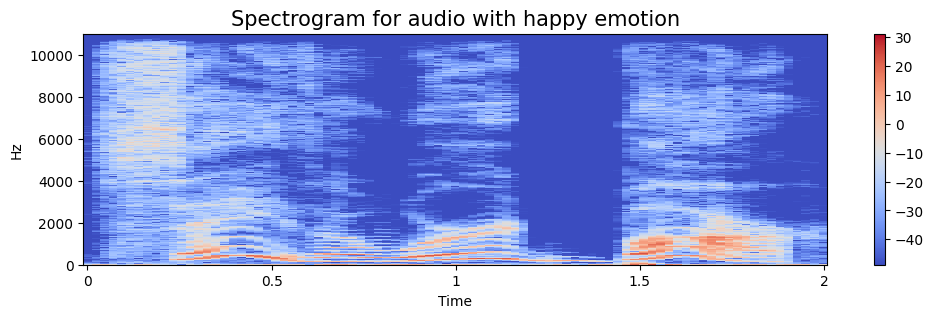

In [11]:
emotion='happy'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

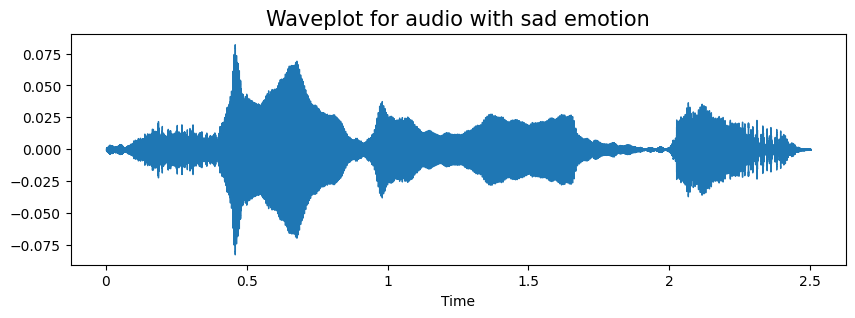

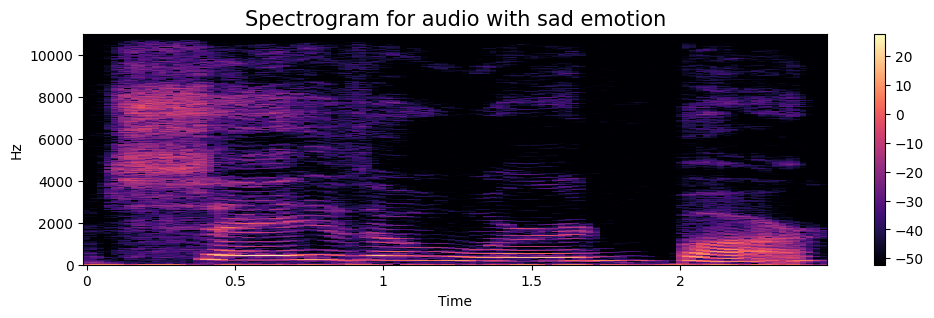

In [12]:
emotion='sad'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

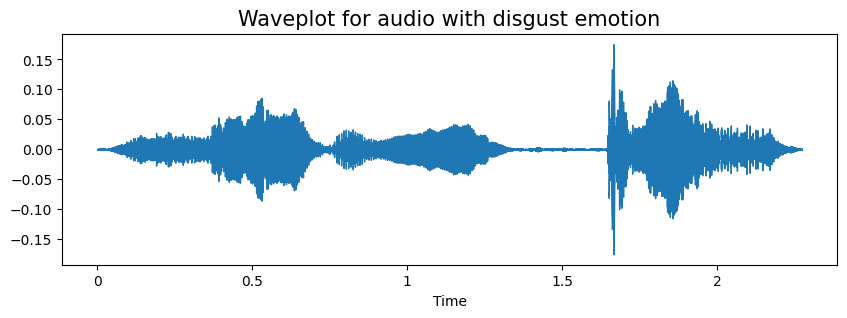

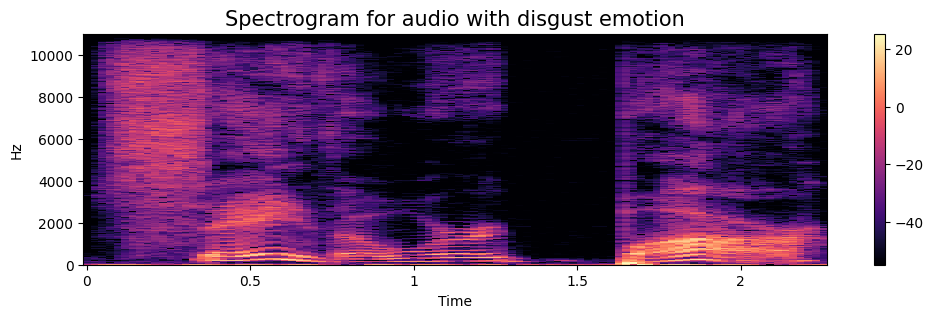

In [13]:
emotion='disgust'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

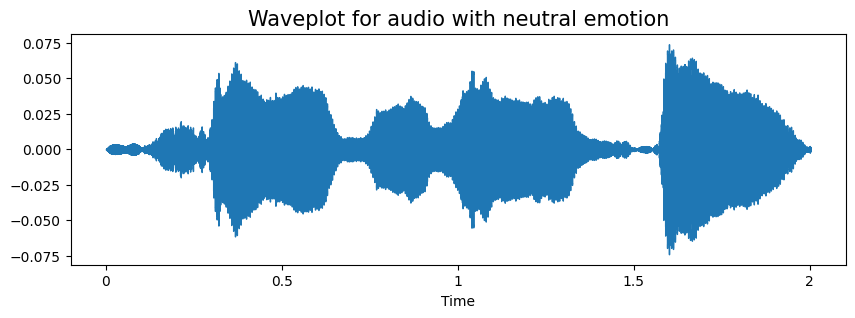

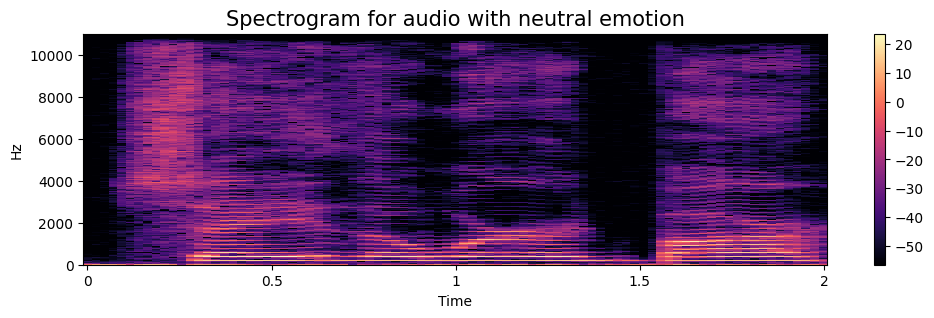

In [14]:
emotion='neutral'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    n_steps = 12 * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

path = np.array(df['path'])[1]
data, sample_rate = librosa.load(path)

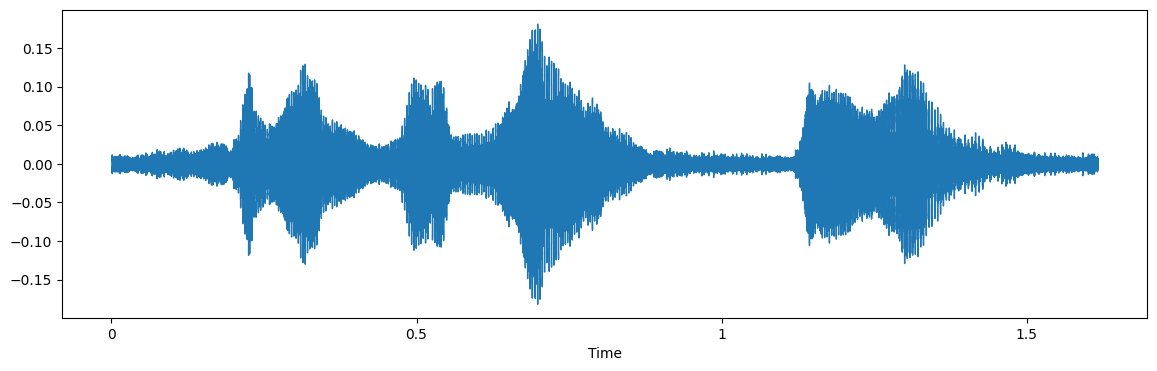

In [16]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

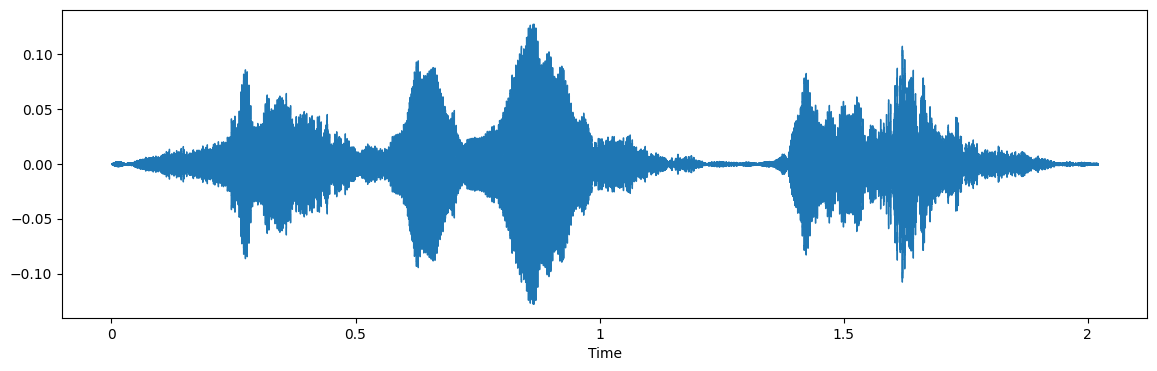

In [17]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

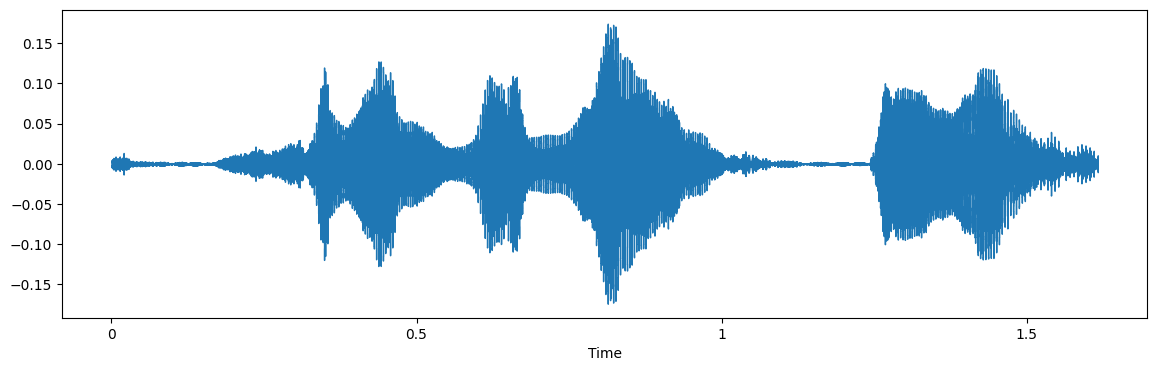

In [18]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

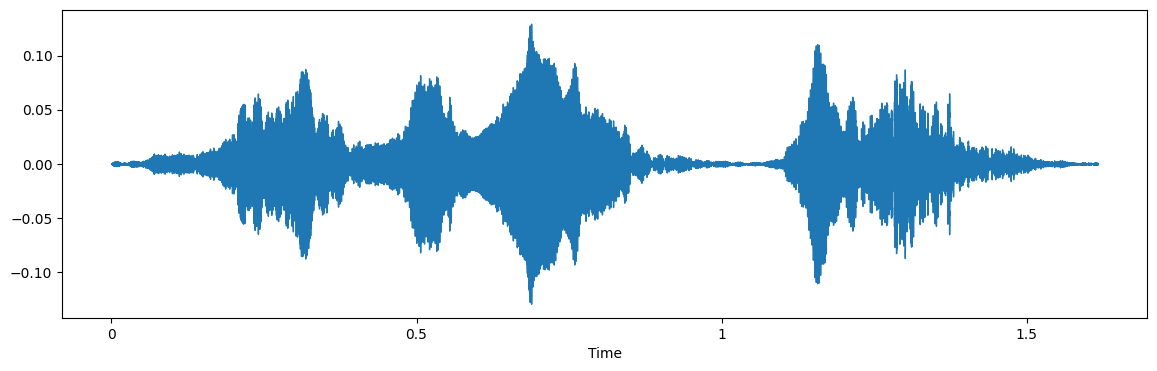

In [19]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


## Preprocessing

In [20]:
def extract_features(data):
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    return result


In [21]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result

In [22]:
X, Y = [], []
for path, emotion in zip(df['path'], df['label']):
    print(path, emotion)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

Tess\OAF_angry\OAF_back_angry.wav angry
Tess\OAF_angry\OAF_bar_angry.wav angry
Tess\OAF_angry\OAF_base_angry.wav angry
Tess\OAF_angry\OAF_bath_angry.wav angry
Tess\OAF_angry\OAF_bean_angry.wav angry
Tess\OAF_angry\OAF_beg_angry.wav angry
Tess\OAF_angry\OAF_bite_angry.wav angry
Tess\OAF_angry\OAF_boat_angry.wav angry
Tess\OAF_angry\OAF_bone_angry.wav angry
Tess\OAF_angry\OAF_book_angry.wav angry
Tess\OAF_angry\OAF_bought_angry.wav angry
Tess\OAF_angry\OAF_burn_angry.wav angry
Tess\OAF_angry\OAF_cab_angry.wav angry
Tess\OAF_angry\OAF_calm_angry.wav angry
Tess\OAF_angry\OAF_came_angry.wav angry
Tess\OAF_angry\OAF_cause_angry.wav angry
Tess\OAF_angry\OAF_chain_angry.wav angry
Tess\OAF_angry\OAF_chair_angry.wav angry
Tess\OAF_angry\OAF_chalk_angry.wav angry
Tess\OAF_angry\OAF_chat_angry.wav angry
Tess\OAF_angry\OAF_check_angry.wav angry
Tess\OAF_angry\OAF_cheek_angry.wav angry
Tess\OAF_angry\OAF_chief_angry.wav angry
Tess\OAF_angry\OAF_choice_angry.wav angry
Tess\OAF_angry\OAF_cool_angry.wa

In [23]:
len(X), len(Y), df.path.shape

(8400, 8400, (2800,))

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Features.to_csv('features_tess.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-398.608246,75.117401,-21.772625,-19.993965,2.985435,13.788044,-19.953243,-7.025359,-5.187742,1.833246,...,5.901571,9.498296,6.048398,1.720645,-2.132165,5.757223,9.964634,2.260837,-2.038578,angry
1,-231.192548,28.089779,-7.011255,-14.191078,-0.667787,4.039691,-5.629298,-6.598788,-3.035267,1.379518,...,2.708533,4.922407,2.431841,-2.224814,-2.609379,3.389520,5.342997,2.246550,-3.139927,angry
2,-433.174683,45.838692,-52.567738,-5.295214,5.816197,-23.503971,2.894077,11.254956,1.060427,-0.203794,...,17.145124,9.897344,3.940747,2.917552,5.234280,-7.870265,-4.036549,9.036828,5.911900,angry
3,-469.633392,101.032448,1.475380,-32.444489,-9.686409,14.370925,-1.291309,-5.177819,-9.246144,5.867874,...,9.017987,13.152020,2.887668,2.447105,-1.420831,2.904995,9.037380,4.569520,3.737320,angry
4,-431.159116,81.812985,-0.120834,-28.545373,-9.925485,10.336094,0.410488,-5.367442,-7.832266,1.979631,...,8.764324,12.552295,2.861333,1.611398,-1.889660,2.986315,8.001400,5.074380,2.446037,angry


In [25]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [26]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 40), (6300, 7), (2100, 40), (2100, 7))

In [28]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 40), (6300, 7), (2100, 40), (2100, 7))

In [29]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 40, 1), (6300, 7), (2100, 40, 1), (2100, 7))

## CNN Model

In [30]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,871 (2.06 MB)

 Trainable params: 540,871 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.3073 - loss: 1.6676 - val_accuracy: 0.7471 - val_loss: 0.6677 - learning_rate: 0.0010
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6733 - loss: 0.8417 - val_accuracy: 0.8805 - val_loss: 0.3625 - learning_rate: 0.0010
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8223 - loss: 0.5120 - val_accuracy: 0.9324 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8736 - loss: 0.3797 - val_accuracy: 0.9300 - val_loss: 0.2070 - learning_rate: 0.0010
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9178 - loss: 0.2731 - val_accuracy: 0.9562 - val_loss: 0.1371 - learning_rate: 0.0010
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9293 - loss: 0.2157 - val_accuracy: 0.9700 - val_loss: 0.0873 - learning_rate: 0.0010
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9469 - loss: 0.1734 - val_ac

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9957 - loss: 0.0197
Accuracy of our model on test data :  99.52380657196045 %


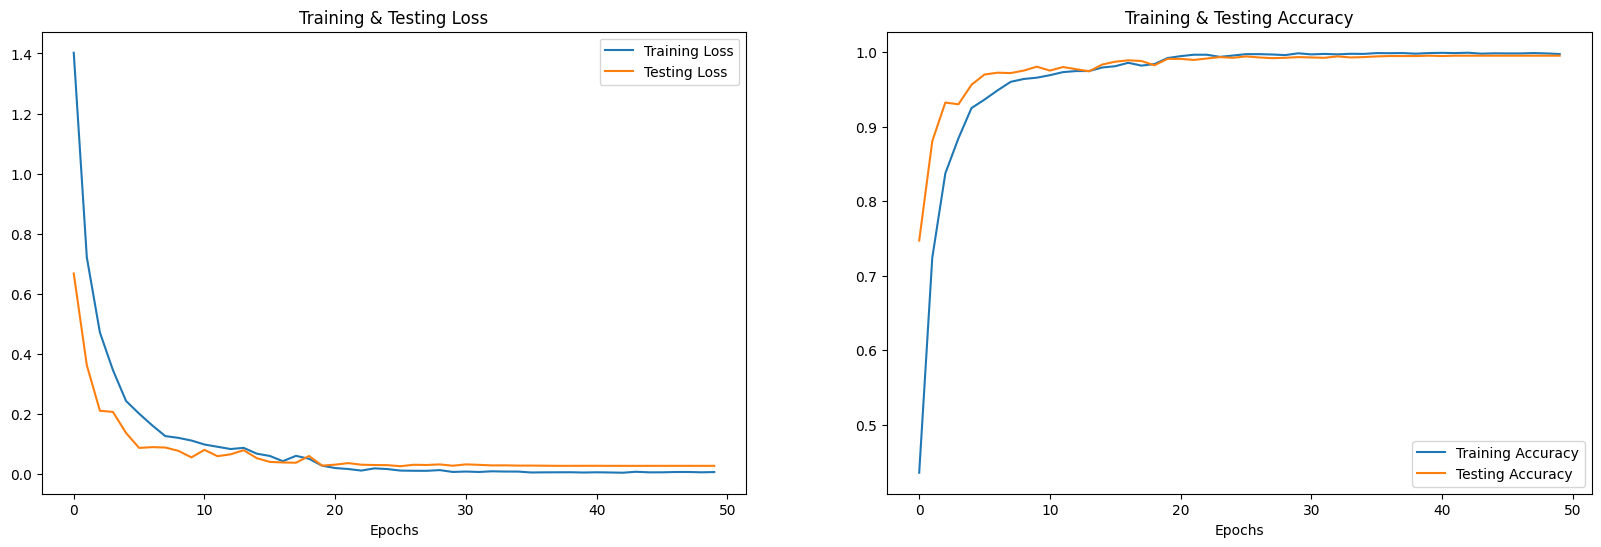

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [34]:
output = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
output['Predicted Labels'] = y_pred.flatten()
output['Actual Labels'] = y_test.flatten()

output.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,ps,ps
2,neutral,neutral
3,happy,happy
4,ps,ps
5,fear,fear
6,fear,fear
7,sad,sad
8,disgust,disgust
9,fear,fear


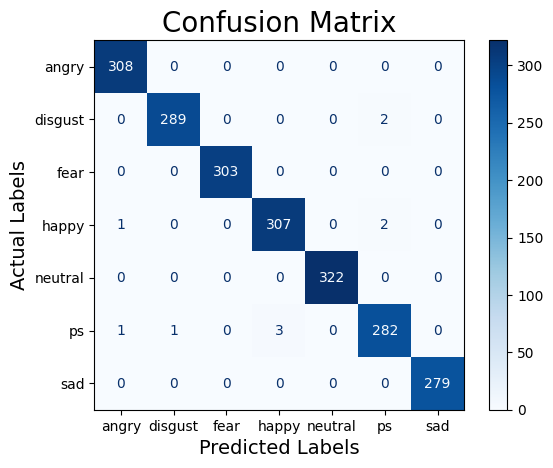

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

actual_labels = np.array(y_test.flatten())
predicted_labels = np.array(y_pred.flatten())

cm = confusion_matrix(actual_labels, predicted_labels, labels=["angry", "disgust", "fear", "happy", "neutral", "ps", "sad"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["angry", "disgust", "fear", "happy", "neutral", "ps", "sad"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.99      1.00      1.00       308
     disgust       1.00      0.99      0.99       291
        fear       1.00      1.00      1.00       303
       happy       0.99      0.99      0.99       310
     neutral       1.00      1.00      1.00       322
          ps       0.99      0.98      0.98       287
         sad       1.00      1.00      1.00       279

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



## LSTM Model

In [37]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [38]:
extract_mfcc(df['path'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228361e+00, -5.57365894e-01, -1.83255327e+00,  2.02101514e-01,
        7.27550924e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126286e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722492e-01,  5.11131430e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896276e+00,  9.31392288e+00,  2.08915019e+00, -1.90649128e+00],
      dtype=float32)

In [39]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))

In [40]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [41]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [42]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [43]:
y = y.toarray()

In [44]:
y.shape

(2800, 7)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [46]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,655 (1.17 MB)

 Trainable params: 307,655 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.2164 - loss: 1.8308 - val_accuracy: 0.6000 - val_loss: 1.1345
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5504 - loss: 1.1826 - val_accuracy: 0.7000 - val_loss: 0.9193
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6920 - loss: 0.8739 - val_accuracy: 0.8048 - val_loss: 0.5138
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7822 - loss: 0.5864 - val_accuracy: 0.8548 - val_loss: 0.3547
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8344 - loss: 0.4592 - val_accuracy: 0.8857 - val_loss: 0.3396
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8649 - loss: 0.4224 - val_accuracy: 0.9429 - val_loss: 0.2594
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8935 - loss: 0.3275 - val_accuracy: 0.9333 - val_loss: 0.2180
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9151 - loss: 0.2734 - val_accuracy: 0.

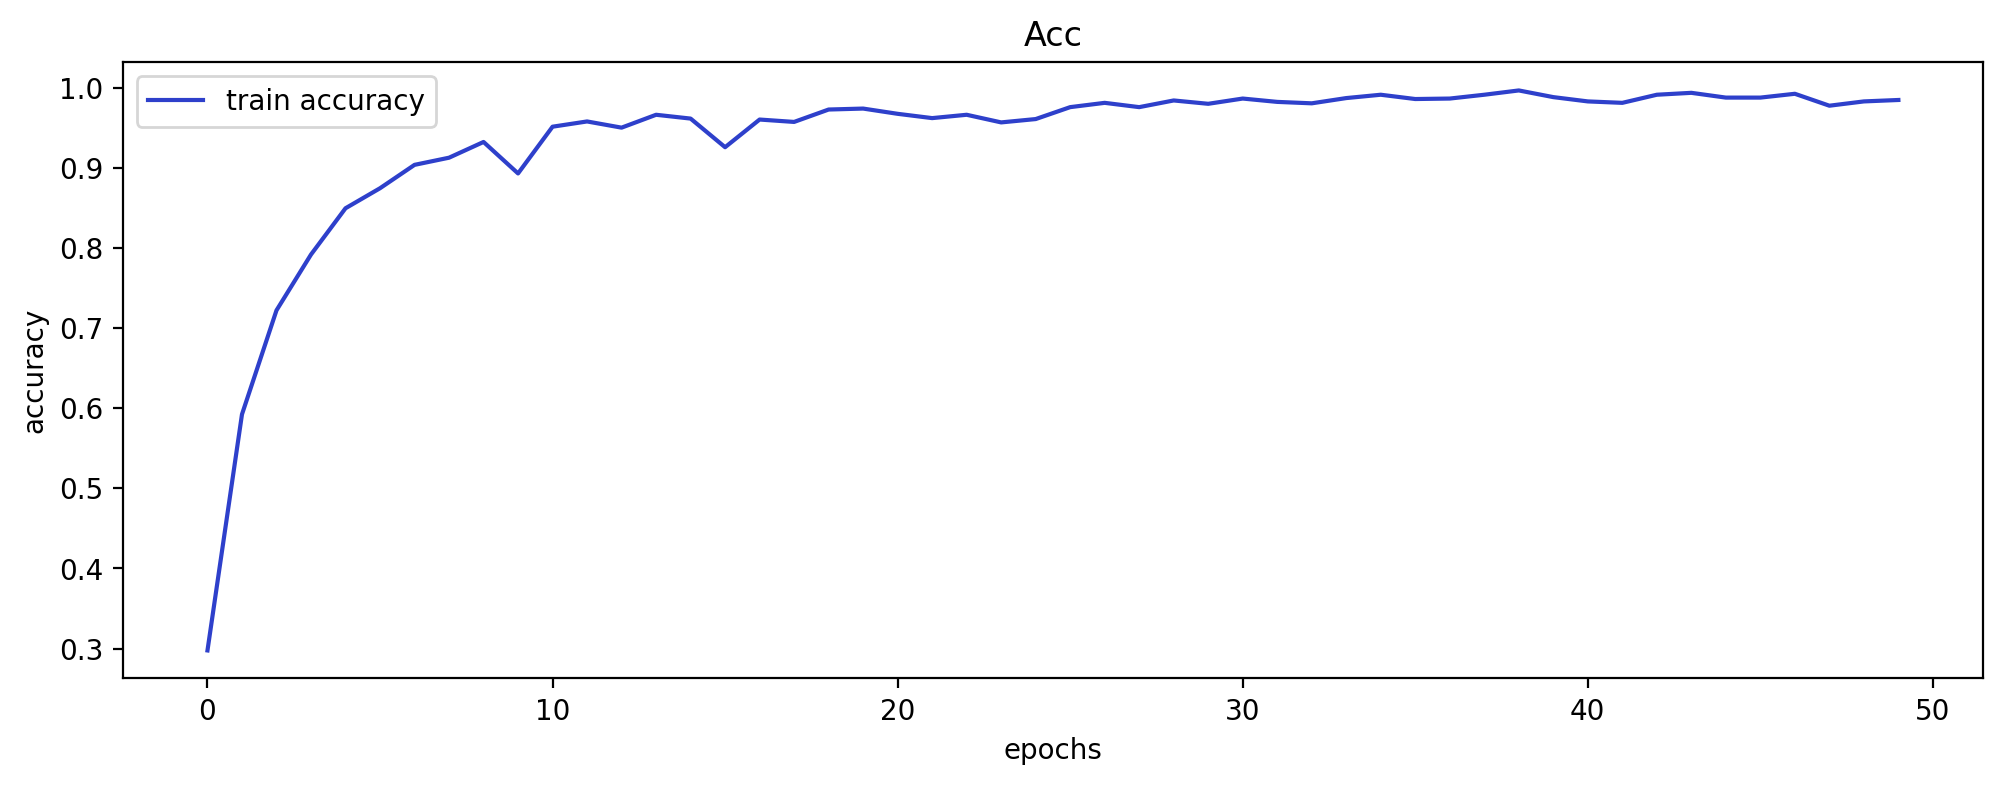

In [48]:
epochs = list(range(50))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acc')
plt.legend()
plt.show()

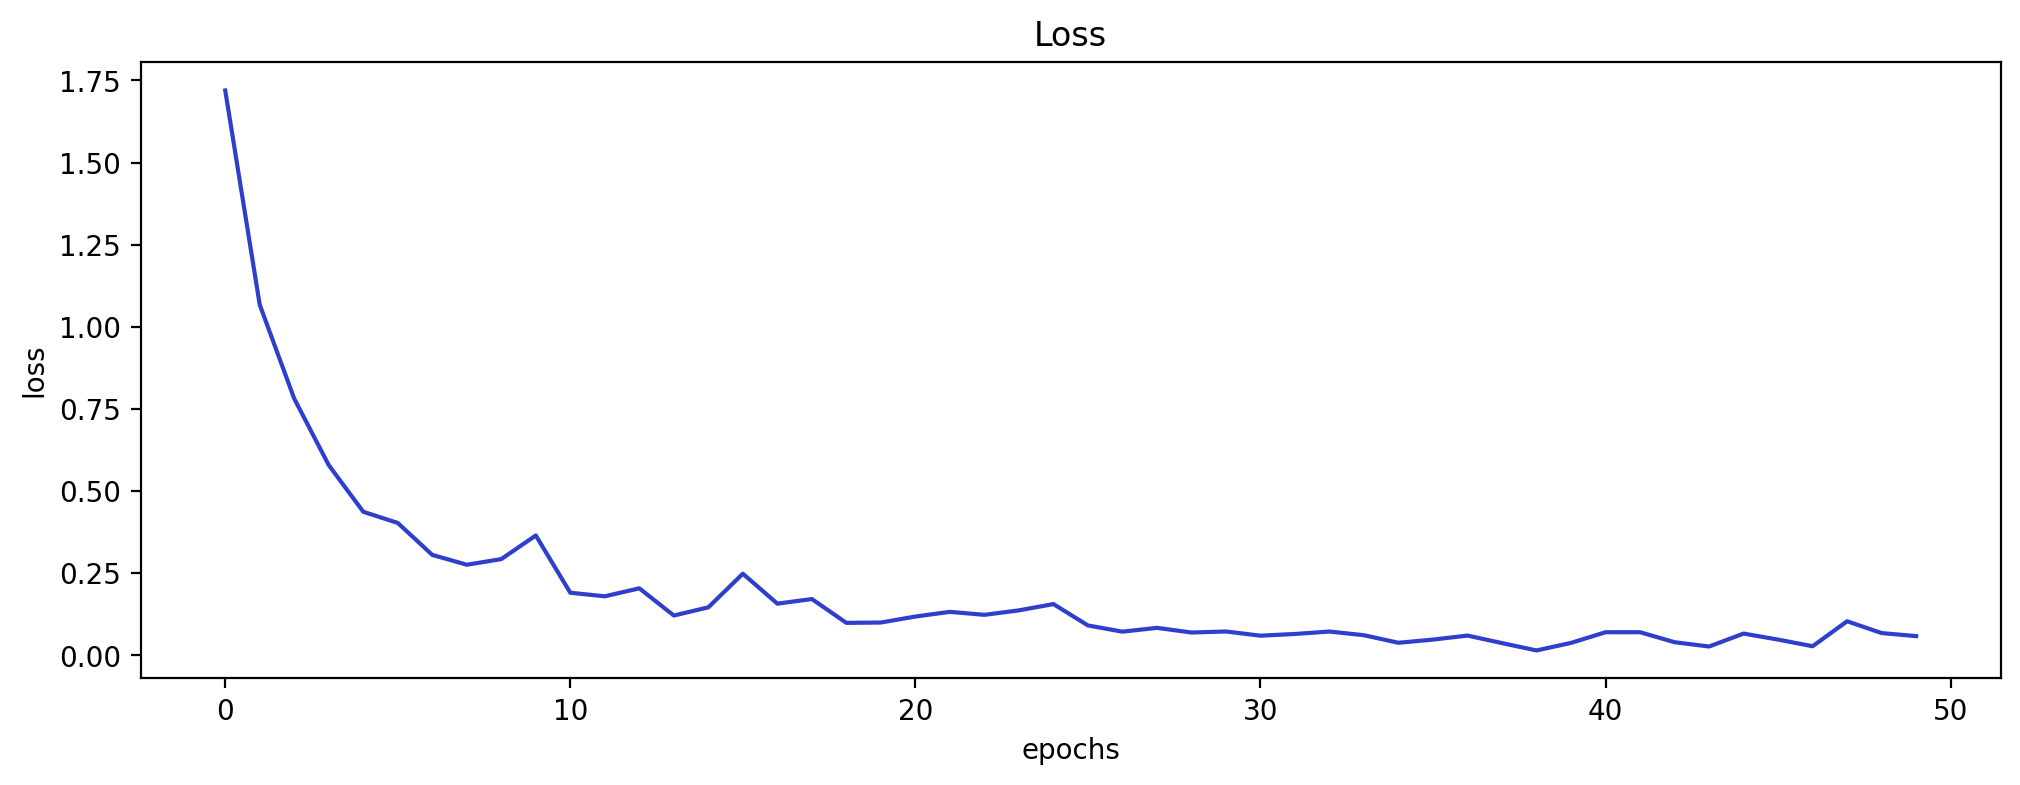

In [49]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

In [50]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy}')

22/22 - 1s - 27ms/step - accuracy: 0.9800 - loss: 0.0711
Test Accuracy: 0.9800000190734863
